In [1]:
%load_ext ipycache
%load_ext autoreload
%autoreload 2

/home/ubuntu/.virtualenvs/catacq/lib/python3.6/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/home/ubuntu/.virtualenvs/catacq/lib/python3.6/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


# Initialization
## Hyperparameters for discovery

In [2]:
adsorbate = 'CO'
target_energy = -0.67
initial_training_size = 200
batch_size = 200
quantile_cutoff = 0.95

## Gather validation data

In [3]:
import random
import ase.db


db_dir = '../pull_data/%s/' % adsorbate
db = ase.db.connect(db_dir + '%s.db' % adsorbate)
rows = list(db.select())
random.Random(42).shuffle(rows)


def parse_rows(rows):
    features = []
    labels = []
    surfaces = []

    for row in rows:
        features.append(row.id)
        data = row.data
        labels.append(data['adsorption_energy'])
        surface = (data['mpid'], data['miller'], data['shift'], data['top'])
        surfaces.append(surface)

    return features, labels, surfaces


training_features, training_labels, training_surfaces = parse_rows(rows[:initial_training_size])
sampling_features, sampling_labels, sampling_surfaces = parse_rows(rows[initial_training_size:])

In [4]:
import json

with open('../pull_data/CO/CO.json') as f:
    co_json = json.load(f)

# Shuffle JSON the same way that I shuffle the rows
random.Random(42).shuffle(co_json)

In [5]:
co_json[0]

{'adsorbate': 'CO',
 'mpid': 'mp-561320',
 'miller': [0, 0, 1],
 'shift': 0.0,
 'top': True,
 'coordination': 'Pb-S',
 'neighborcoord': ['Pb:Pb-S-S-S-S', 'S:Pb-Pb-Pb-Pb'],
 'energy': -0.3781929800000068}

In [6]:
co_json[4503]

{'adsorbate': 'CO',
 'mpid': 'mp-985825',
 'miller': [2, 0, 1],
 'shift': 0.18105584250000006,
 'top': True,
 'coordination': 'Al-Al',
 'neighborcoord': ['Al:Al-Al-Al-Al-Cu-Cu', 'Al:Al-Al-Al-Al-Cu-Cu'],
 'energy': -0.23871605000001317}

In [7]:
co_json[200]

{'adsorbate': 'CO',
 'mpid': 'mp-2404',
 'miller': [2, 1, 0],
 'shift': 0.020833333333333426,
 'top': True,
 'coordination': 'Al-Al-Ca',
 'neighborcoord': ['Al:Al-Al-Al-Ca-Ca-Ca-Ca',
  'Ca:Al-Al-Al-Al-Al-Ca-Ca',
  'Al:Al-Al-Al-Al-Al-Ca-Ca-Ca-Ca-Ca'],
 'energy': -1.2399316700000096}

In [8]:
len(training_features)

200

In [9]:
len(training_labels)

200

In [10]:
len(training_surfaces)

200

In [11]:
len(sampling_features)

18905

In [12]:
len(sampling_labels)

18905

In [13]:
len(sampling_surfaces)

18905

In [14]:
training_features[0]

4504

In [15]:
training_labels[0]

-0.3781929800000068

In [16]:
training_surfaces[0]

('mp-561320', array([0, 0, 1]), 0.0, True)

In [17]:
sampling_features[0]

4101

In [18]:
sampling_labels[0]

-1.2399316700000096

In [19]:
sampling_surfaces[1]

('mp-542640', array([2, 1, 0]), 0.046948877499999875, True)

In [20]:
test_idx = 2772

In [21]:
for i, tf in enumerate(training_features):
    if tf==test_idx:
        print('found it!')
        print(i)
        list_idx = i

found it!
175


In [22]:
training_features[list_idx]

2772

In [23]:
for i, tf in enumerate(sampling_features):
    if tf==test_idx:
        print('found it!')
        print(i)
        list_idx = i

In [24]:
sampling_features[list_idx]

11812

In [25]:
test_bulk = 'mp-672259'

In [26]:
#test_bulk = 'mp-568264'

In [27]:
len(sampling_surfaces)

18905

In [28]:
len(training_surfaces)

200

In [29]:
for i, s in enumerate(sampling_surfaces):
    if s[0] == test_bulk:
        print('found it!')
        print(i)
        list_idx = i

found it!
11060


In [30]:
for i, s in enumerate(training_surfaces):
    if s[0] == test_bulk:
        print('found it!')
        print(i)
        list_idx = i

In [31]:
sampling_surfaces[list_idx]

('mp-672259', array([1, 1, 1]), 0.13, False)

In [32]:
training_surfaces[0]

('mp-561320', array([0, 0, 1]), 0.0, True)

In [33]:
training_surfaces[199]

('mp-20738', array([1, 0, 1]), 0.4999999999999999, True)

In [34]:
sampling_surfaces[0]

('mp-2404', array([2, 1, 0]), 0.020833333333333426, True)

In [ ]:
len(discoverer.sampling_surfaces)

In [ ]:
len(discoverer.training_surfaces)

In [58]:
for i, s in enumerate(discoverer.sampling_surfaces):
    if s[0] == test_bulk:
        print('found it!')
        print(i)
        list_idx = i

In [59]:
for i, s in enumerate(discoverer.training_surfaces):
    if s[0] == test_bulk:
        print('found it!')
        print(i)
        list_idx = i

In [60]:
discoverer.training_surfaces[0]

('mp-561320', (0, 0, 1), 0.0, True)

In [61]:
discoverer.sampling_surfaces[0]

('mp-2404', (2, 1, 0), 0.020833333333333426, True)

In [62]:
discoverer.training_surfaces[200]

('mp-998512', (0, 1, 0), 0.19, True)

# Hallucinate
## Initialize

In [37]:
import sys
sys.path.insert(0, '../../')
from src.discoverers.adsorption.mms_nullmodel import MultiscaleDiscovererNullModel


# Initialize
discoverer = MultiscaleDiscovererNullModel(
                                  json_list=co_json,
                                  db_dir=db_dir,
                                  target_energy=target_energy,
                                  quantile_cutoff=quantile_cutoff,
                                  batch_size=batch_size,
                                  training_features=training_features,
                                  training_labels=training_labels,
                                  training_surfaces=training_surfaces,
                                  sampling_features=sampling_features,
                                  sampling_labels=sampling_labels,
                                  sampling_surfaces=sampling_surfaces,
                                  init_train=False  # Set to `False` only for warm starts
                                 )

PRINT: RS-NULL [new] hallucinations with predictions only (no true site observations)


In [38]:
len(discoverer.training_features)

200

In [39]:
len(discoverer.training_labels)

200

In [40]:
len(discoverer.training_surfaces)

200

In [41]:
len(discoverer.sampling_features)

18905

In [42]:
len(discoverer.sampling_labels)

18905

In [43]:
len(discoverer.sampling_surfaces)

18905

## Run

In [44]:
discoverer.simulate_discovery()

/home/ubuntu/.virtualenvs/catacq/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1824: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


PRINT: BEFORE _train:
len(self.training_features
200
len(self.training_labels)
200
len(self.training_surfaces)
400
len(self.sampling_features)
18705
len(self.sampling_labels)
18705
len(self.sampling_surfaces)
18705
-
PRINT: AFTER _train:
len(self.training_features
400
len(self.training_labels)
400
len(self.training_surfaces)
400
len(self.sampling_features)
18705
len(self.sampling_labels)
18705
len(self.sampling_surfaces)
18705
----------
PRINT: BEFORE _train:
len(self.training_features
400
len(self.training_labels)
400
len(self.training_surfaces)
600
len(self.sampling_features)
18505
len(self.sampling_labels)
18505
len(self.sampling_surfaces)
18505
-
PRINT: AFTER _train:
len(self.training_features
600
len(self.training_labels)
600
len(self.training_surfaces)
600
len(self.sampling_features)
18505
len(self.sampling_labels)
18505
len(self.sampling_surfaces)
18505
----------
PRINT: BEFORE _train:
len(self.training_features
600
len(self.training_labels)
600
len(self.training_surfaces)
800
l

-
PRINT: AFTER _train:
len(self.training_features
4000
len(self.training_labels)
4000
len(self.training_surfaces)
4000
len(self.sampling_features)
15105
len(self.sampling_labels)
15105
len(self.sampling_surfaces)
15105
----------
PRINT: BEFORE _train:
len(self.training_features
4000
len(self.training_labels)
4000
len(self.training_surfaces)
4200
len(self.sampling_features)
14905
len(self.sampling_labels)
14905
len(self.sampling_surfaces)
14905
-
PRINT: AFTER _train:
len(self.training_features
4200
len(self.training_labels)
4200
len(self.training_surfaces)
4200
len(self.sampling_features)
14905
len(self.sampling_labels)
14905
len(self.sampling_surfaces)
14905
----------
PRINT: BEFORE _train:
len(self.training_features
4200
len(self.training_labels)
4200
len(self.training_surfaces)
4400
len(self.sampling_features)
14705
len(self.sampling_labels)
14705
len(self.sampling_surfaces)
14705
-
PRINT: AFTER _train:
len(self.training_features
4400
len(self.training_labels)
4400
len(self.training_

PRINT: BEFORE _train:
len(self.training_features
7600
len(self.training_labels)
7600
len(self.training_surfaces)
7800
len(self.sampling_features)
11305
len(self.sampling_labels)
11305
len(self.sampling_surfaces)
11305
-
PRINT: AFTER _train:
len(self.training_features
7800
len(self.training_labels)
7800
len(self.training_surfaces)
7800
len(self.sampling_features)
11305
len(self.sampling_labels)
11305
len(self.sampling_surfaces)
11305
----------
PRINT: BEFORE _train:
len(self.training_features
7800
len(self.training_labels)
7800
len(self.training_surfaces)
8000
len(self.sampling_features)
11105
len(self.sampling_labels)
11105
len(self.sampling_surfaces)
11105
-
PRINT: AFTER _train:
len(self.training_features
8000
len(self.training_labels)
8000
len(self.training_surfaces)
8000
len(self.sampling_features)
11105
len(self.sampling_labels)
11105
len(self.sampling_surfaces)
11105
----------
PRINT: BEFORE _train:
len(self.training_features
8000
len(self.training_labels)
8000
len(self.training_s

-
PRINT: AFTER _train:
len(self.training_features
11400
len(self.training_labels)
11400
len(self.training_surfaces)
11400
len(self.sampling_features)
7705
len(self.sampling_labels)
7705
len(self.sampling_surfaces)
7705
----------
PRINT: BEFORE _train:
len(self.training_features
11400
len(self.training_labels)
11400
len(self.training_surfaces)
11600
len(self.sampling_features)
7505
len(self.sampling_labels)
7505
len(self.sampling_surfaces)
7505
-
PRINT: AFTER _train:
len(self.training_features
11600
len(self.training_labels)
11600
len(self.training_surfaces)
11600
len(self.sampling_features)
7505
len(self.sampling_labels)
7505
len(self.sampling_surfaces)
7505
----------
PRINT: BEFORE _train:
len(self.training_features
11600
len(self.training_labels)
11600
len(self.training_surfaces)
11800
len(self.sampling_features)
7305
len(self.sampling_labels)
7305
len(self.sampling_surfaces)
7305
-
PRINT: AFTER _train:
len(self.training_features
11800
len(self.training_labels)
11800
len(self.trainin

PRINT: BEFORE _train:
len(self.training_features
15000
len(self.training_labels)
15000
len(self.training_surfaces)
15200
len(self.sampling_features)
3905
len(self.sampling_labels)
3905
len(self.sampling_surfaces)
3905
-
PRINT: AFTER _train:
len(self.training_features
15200
len(self.training_labels)
15200
len(self.training_surfaces)
15200
len(self.sampling_features)
3905
len(self.sampling_labels)
3905
len(self.sampling_surfaces)
3905
----------
PRINT: BEFORE _train:
len(self.training_features
15200
len(self.training_labels)
15200
len(self.training_surfaces)
15400
len(self.sampling_features)
3705
len(self.sampling_labels)
3705
len(self.sampling_surfaces)
3705
-
PRINT: AFTER _train:
len(self.training_features
15400
len(self.training_labels)
15400
len(self.training_surfaces)
15400
len(self.sampling_features)
3705
len(self.sampling_labels)
3705
len(self.sampling_surfaces)
3705
----------
PRINT: BEFORE _train:
len(self.training_features
15400
len(self.training_labels)
15400
len(self.training

-
PRINT: AFTER _train:
len(self.training_features
18800
len(self.training_labels)
18800
len(self.training_surfaces)
18800
len(self.sampling_features)
305
len(self.sampling_labels)
305
len(self.sampling_surfaces)
305
----------
PRINT: BEFORE _train:
len(self.training_features
18800
len(self.training_labels)
18800
len(self.training_surfaces)
19000
len(self.sampling_features)
105
len(self.sampling_labels)
105
len(self.sampling_surfaces)
105
-
PRINT: AFTER _train:
len(self.training_features
19000
len(self.training_labels)
19000
len(self.training_surfaces)
19000
len(self.sampling_features)
105
len(self.sampling_labels)
105
len(self.sampling_surfaces)
105
----------
PRINT: BEFORE _train:
len(self.training_features
19000
len(self.training_labels)
19000
len(self.training_surfaces)
19105
len(self.sampling_features)
0
len(self.sampling_labels)
0
len(self.sampling_surfaces)
0
-
PRINT: AFTER _train:
len(self.training_features
19105
len(self.training_labels)
19105
len(self.training_surfaces)
19105


In [ ]:
# Or load the last run
discoverer.load_last_run()

## Analyze

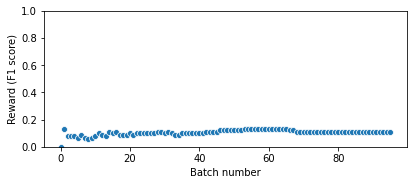

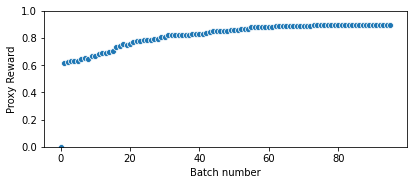

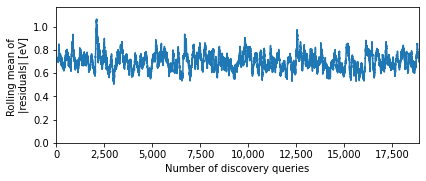

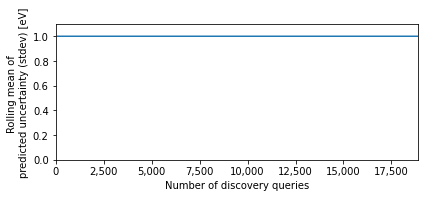

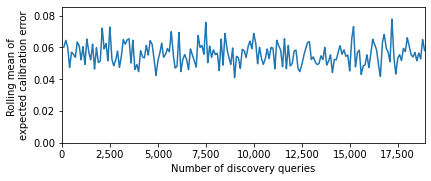

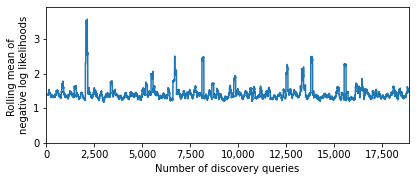

In [45]:
reward_fig, proxy_fig, accuracy_fig, uncertainty_fig, calibration_fig, nll_fig = discoverer.plot_performance(window=100)